In [36]:
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import sklearn 
import matplotlib

# Data visu 

In [37]:
#data importation 
data = pd.read_csv("datas/simulated_4K_cloud_gaming_dataset.csv")

print("dataframe information gathering ")

print (data.head())
print (data.index)
print (data.columns)
print (data.dtypes)
print (data.info())
print (data.describe())




dataframe information gathering 
   CPU_usage  GPU_usage  Bandwidth_MBps  Latency_ms  FrameRate_fps  Jitter_ms  \
0         71         65       19.770323   66.202388      59.107060  13.085300   
1         34         40        8.092595   32.207380      57.969683   8.567330   
2         91         55       16.841666  133.478904      52.248079   1.129479   
3         80         73       15.702267  125.328933      38.382477  10.944737   
4         40         76       11.227322  111.041017      33.949608  18.508754   

   QoE_score  
0          3  
1          3  
2          1  
3          1  
4          2  
RangeIndex(start=0, stop=1000, step=1)
Index(['CPU_usage', 'GPU_usage', 'Bandwidth_MBps', 'Latency_ms',
       'FrameRate_fps', 'Jitter_ms', 'QoE_score'],
      dtype='object')
CPU_usage           int64
GPU_usage           int64
Bandwidth_MBps    float64
Latency_ms        float64
FrameRate_fps     float64
Jitter_ms         float64
QoE_score           int64
dtype: object
<class 'pandas.co

# Data Cleaning 

In [38]:
print (data.shape)

(1000, 7)


In [39]:
data = data.dropna()
data = data.drop_duplicates()

In [40]:
print (data.shape)

(1000, 7)


# Visualisation

In [41]:
print(data['QoE_score'].value_counts())

QoE_score
3    379
2    312
1    222
4     84
5      3
Name: count, dtype: int64


## Déséquilibre des classes (ou des notes de QoE à gérer)

<Figure size 1000x600 with 0 Axes>

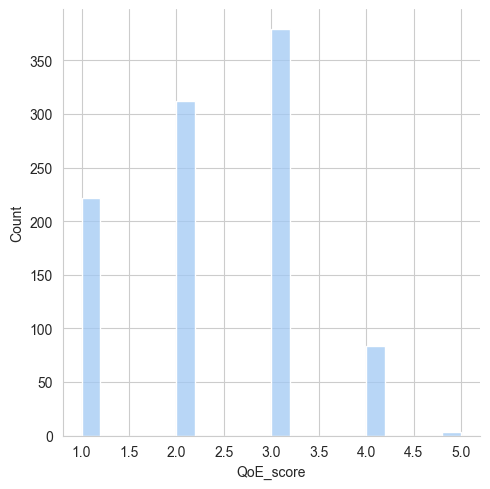

In [42]:
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.displot(data['QoE_score'])
plt.show()

### View of key features 

<Axes: xlabel='QoE_score', ylabel='Latency_ms'>

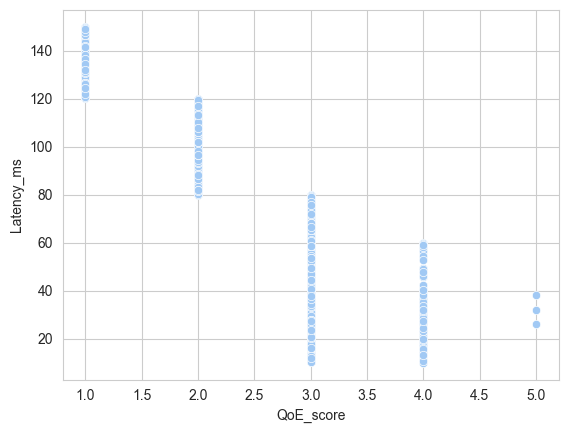

In [43]:
sns.scatterplot(data = data, x = 'QoE_score', y = 'Latency_ms')

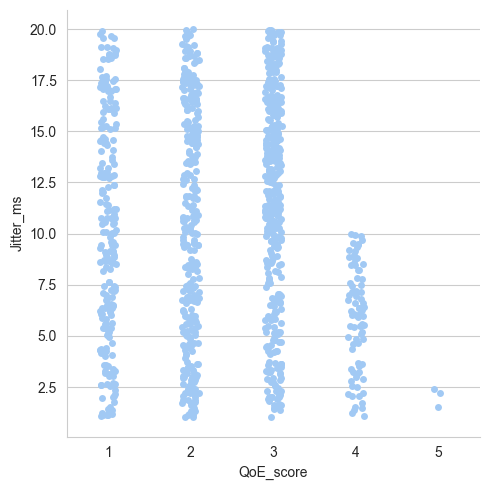

In [44]:
sns.catplot(data= data, x='QoE_score', y = 'Jitter_ms')

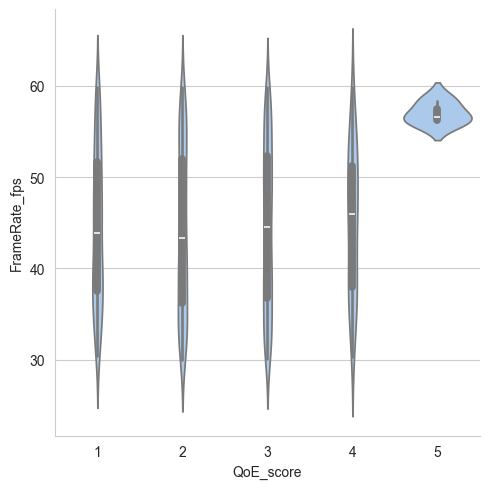

In [45]:
sns.catplot(data= data,kind='violin', x='QoE_score', y = 'FrameRate_fps')

<Axes: xlabel='QoE_score', ylabel='Bandwidth_MBps'>

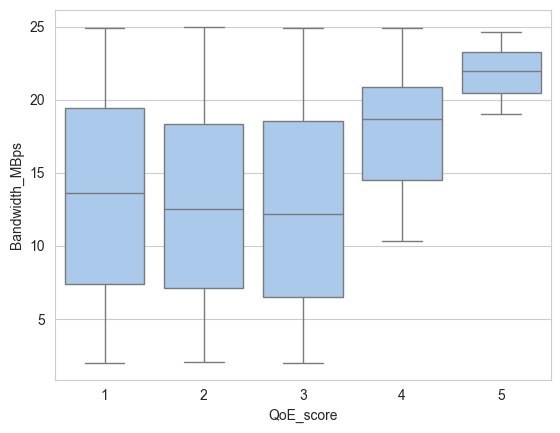

In [46]:
sns.boxplot(data=data, x='QoE_score', y= 'Bandwidth_MBps')

<Axes: xlabel='QoE_score', ylabel='CPU_usage'>

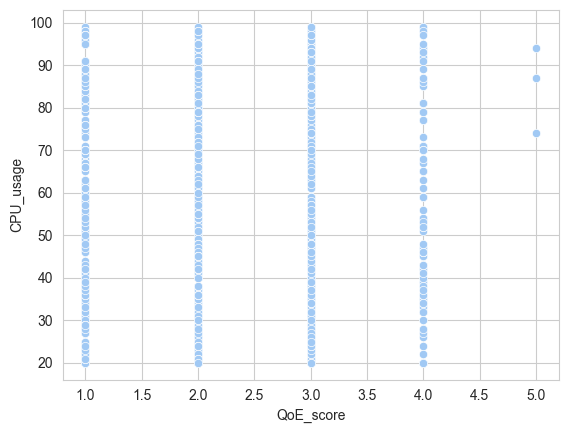

In [47]:
sns.scatterplot(data = data, x = 'QoE_score', y = 'CPU_usage')


<Axes: xlabel='QoE_score', ylabel='GPU_usage'>

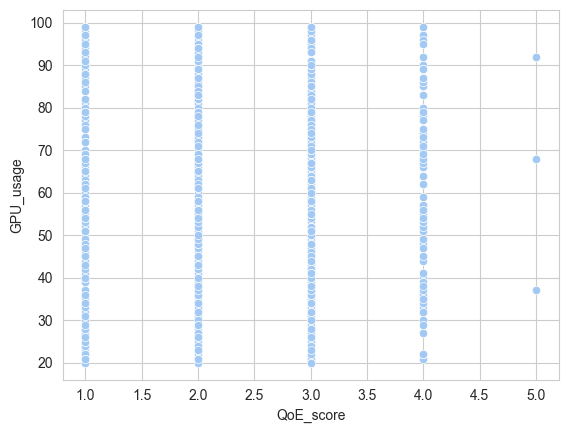

In [48]:
sns.scatterplot(data = data, x = 'QoE_score', y = 'GPU_usage')


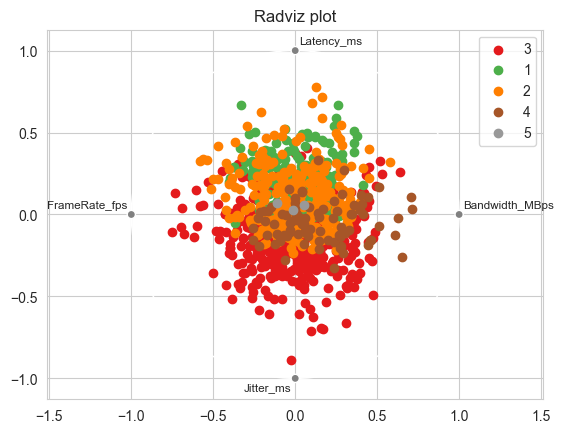

In [49]:
from pandas.plotting import radviz 

cols = ['Bandwidth_MBps', 'Latency_ms', 'FrameRate_fps', 'Jitter_ms', 'QoE_score']
radviz(data[cols], class_column='QoE_score', colormap='Set1')
plt.title('Radviz plot')
plt.show()


# Models training and comparaison of performance

In [51]:
X = data.drop('QoE_score', axis=1)
y = data['QoE_score']

In [52]:
from sklearn.model_selection import  train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [54]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor


In [55]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso': Lasso(),
    'RandomForestRegressor' : RandomForestRegressor(random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'DecisionTreeRegressor' : DecisionTreeRegressor(random_state=42),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'XGBRegressor': XGBRegressor(random_state = 42, verbosity = 0)
}

In [56]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [57]:
# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [59]:
# Résultats globaux et erreurs par QoE
results = []
errors_by_class = {}

for name, model in models.items():
    if name in ['LinearRegression', 'Ridge', 'Lasso', 'SVR', 'KNeighborsRegressor']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})
    
    df_temp = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
    class_errors = df_temp.groupby('y_true').apply(lambda g: mean_absolute_error(g['y_true'], g['y_pred']))
    errors_by_class[name] = class_errors

# Convertir en DataFrames
df_results = pd.DataFrame(results).set_index('Model').sort_values('MAE')
df_errors = pd.DataFrame(errors_by_class).T.sort_index()


In [60]:
# Résultats globaux
display(df_results)

# Erreurs par QoE score
print("Erreur absolue moyenne par QoE score :")
display(df_errors)


,MAE,RMSE,R2
Model,,,
XGBRegressor,0.016171,0.114443,0.984220
DecisionTreeRegressor,0.020000,0.141421,0.975903
RandomForestRegressor,0.029700,0.134270,0.978279
GradientBoostingRegressor,0.058205,0.144116,0.974976
SVR,0.270932,0.342437,0.858717
KNeighborsRegressor,0.319333,0.421900,0.785539
LinearRegression,0.342560,0.417534,0.789956
Ridge,0.342586,0.417485,0.790005
Lasso,0.789971,0.911045,-0.000017


Erreur absolue moyenne par QoE score :


y_true,1,2,3,4,5
DecisionTreeRegressor,0.000000,0.000000,0.034188,0.043478,1.000000
GradientBoostingRegressor,0.007632,0.011071,0.106684,0.117619,0.737662
KNeighborsRegressor,0.366154,0.308511,0.241026,0.600000,1.000000
Lasso,1.332857,0.332857,0.667143,1.667143,2.667143
LinearRegression,0.303766,0.245517,0.376721,0.636565,1.227375
RandomForestRegressor,0.001231,0.000106,0.043590,0.126087,0.820000
Ridge,0.304891,0.245120,0.376178,0.638023,1.229330
SVR,0.205008,0.314806,0.213676,0.527357,1.232886
XGBRegressor,0.030826,0.000016,0.006268,0.088976,0.066359


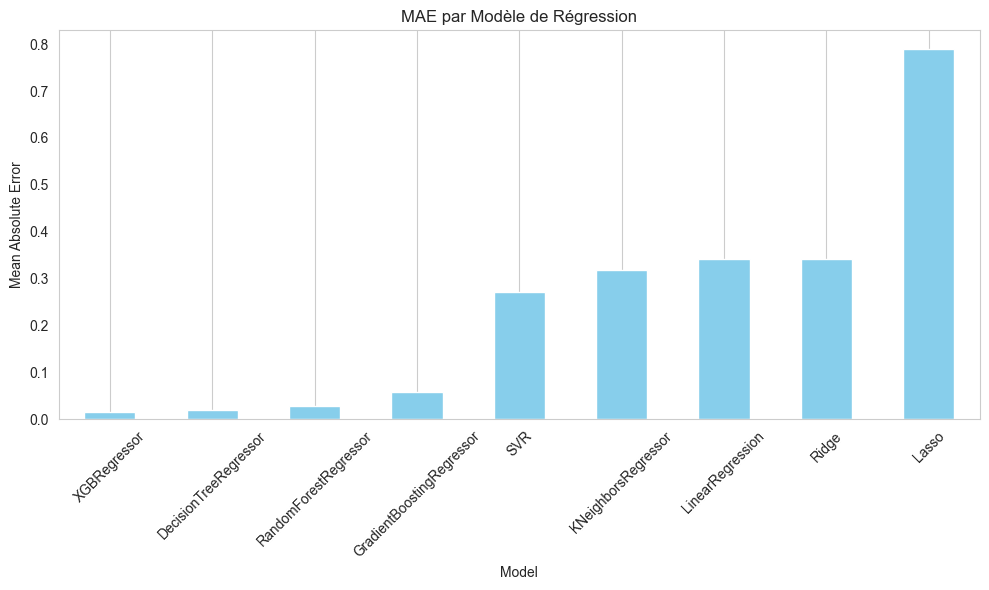

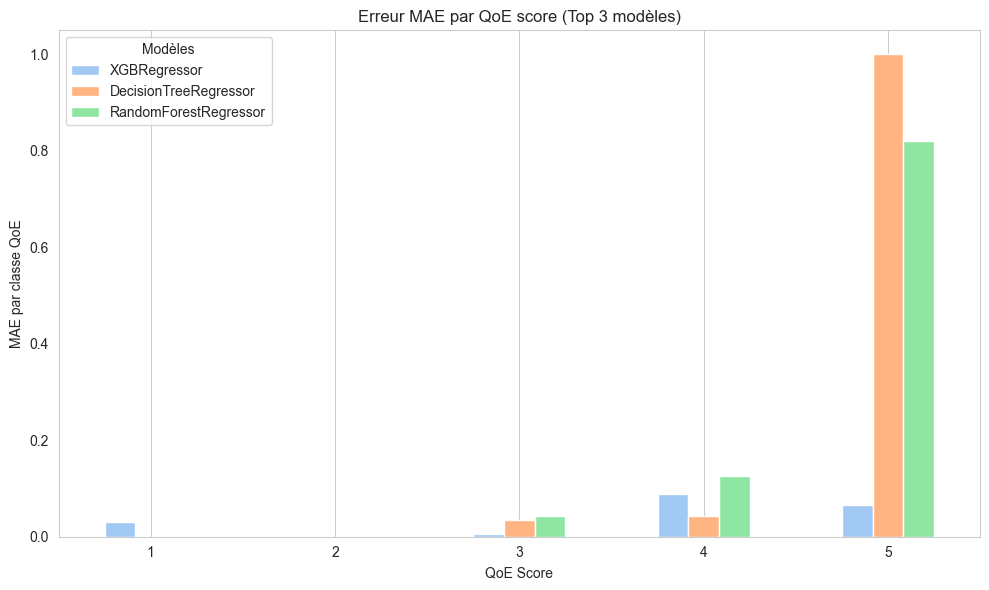

In [61]:
# Plot MAE par modèle
plt.figure(figsize=(10, 6))
df_results['MAE'].plot(kind='bar', color='skyblue')
plt.title('MAE par Modèle de Régression')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot erreurs par QoE pour les 3 meilleurs modèles
top3 = df_results['MAE'].nsmallest(3).index
df_errors.loc[top3].T.plot(kind='bar', figsize=(10, 6))
plt.title('Erreur MAE par QoE score (Top 3 modèles)')
plt.ylabel('MAE par classe QoE')
plt.xlabel('QoE Score')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title='Modèles')
plt.tight_layout()
plt.show()


In [62]:
from sklearn.tree import plot_tree

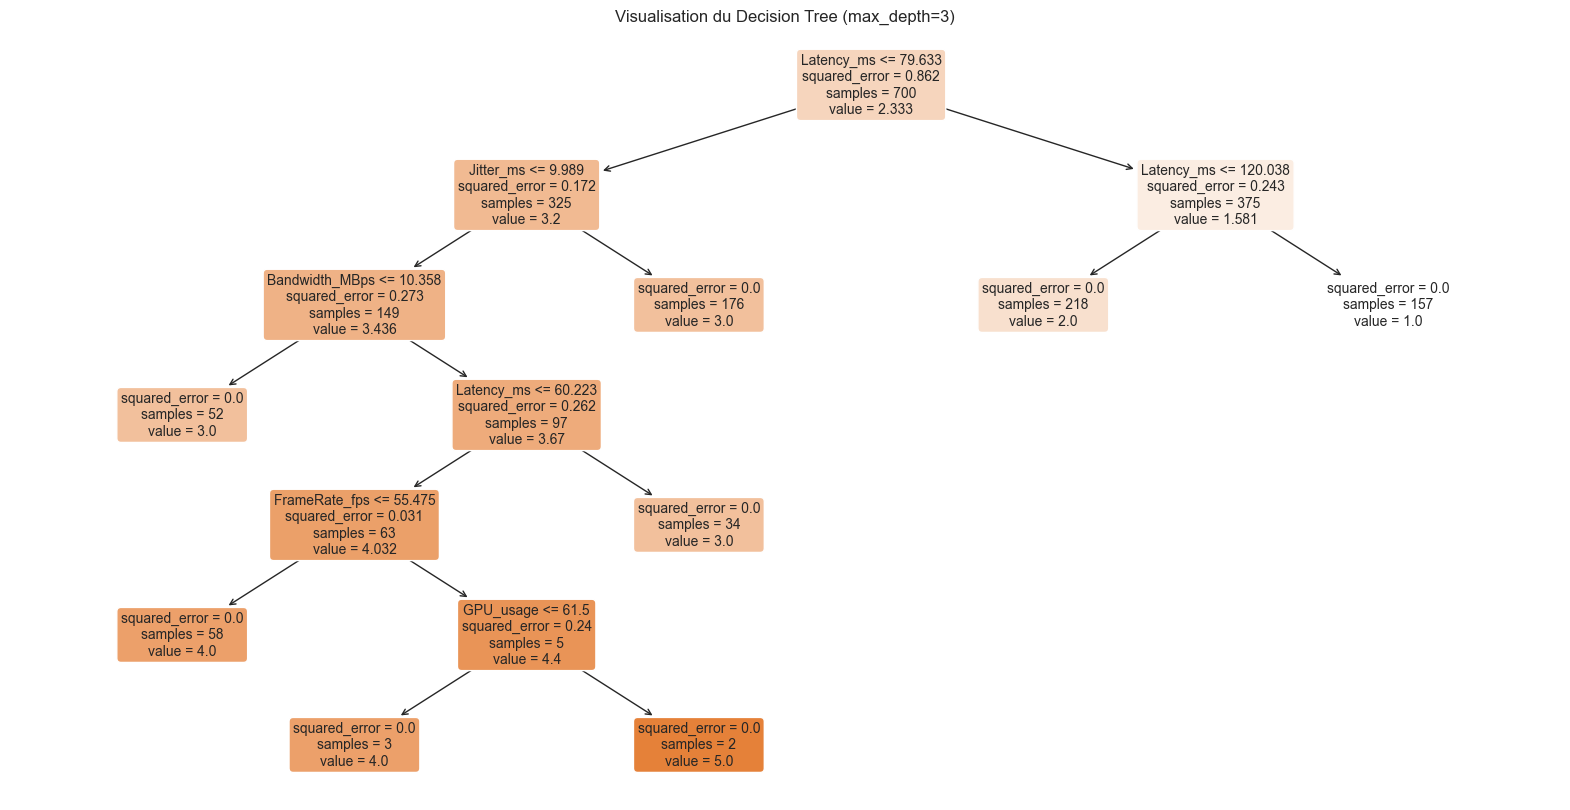

In [64]:
# On récupère l'arbre déjà entraîné
dt_model = models['DecisionTreeRegressor']
# Visualisation
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Visualisation du Decision Tree (max_depth=3)")
plt.show()
